# Qlunc's presentation

Qlunc stands for **Q**uantification of **l**idar **unc**ertainty. It is stored as a public SWE [repository](https://github.com/SWE-UniStuttgart/Qlunc)

Main Qlunc's structure:
![Qlunc basic structure image](Tutorial_Images/Qlunc_GralStructure.JPG)

## Installation

1. Install [anaconda](https://anaconda.org/anaconda/conda)

2. Download or [clone](https://github.com/SWE-UniStuttgart/Qlunc.git) Qlunc´s repository

3. Create an environment and install dependencies. Dependencies list is in the repository. Environment yaml.

Anaconda prompt:

> conda env create -f environment.yml

> conda activate <environment name> (by default Qlunc_Env)
    

    

## Creating objects as python classes (*Qlunc_Classes.py*)
The goal is to create a lidar digital twin to assess the uncertainty of an actual one, before it is built. First we create the lidar components by using python classes. We give some parameter values to these classes, characterizing the components, inculding a function (`uncertainty`), which computes the uncertainty of each "object" . For instance, you might want to create three components with some characteristics defining them and a fucntion describing each one's uncertainty:

In [1]:
# Component 1:
class component1():
    def __init__(self, name, param1, param2, comp1_uncertainty):
        self.name              = name
        self.param1            = param1
        self.param2            = param2
        self.uncertainty       = comp1_uncertainty # python module computing uncertainty of componentA. Defined by the user.

# Component 2:
class component2():
    def __init__(self, name, param1, param2, comp2_uncertainty):
        self.name              = name
        self.param1            = param1
        self.param2            = param2
        self.uncertainty       = comp2_uncertainty # python module computing uncertainty of componentB. Defined by the user.

# Component 3:
class component3():
    def __init__(self, name, param1, param2,param3 ,comp3_uncertainty):
        self.name              = name
        self.param1            = param1
        self.param2            = param2
        self.param3            = param3
        self.uncertainty       = comp3_uncertainty # python module computing uncertainty of componentC. Defined by the user.

Then, this "virtual objects", representing the actual lidar components, are encapsulated into another python class representing the actual lidar module. So, having the components we can create 2 different modules; `module1` and `module2`, each of them containing two and one of the components created above, respectively. They also contain a uncertainty function which computes uncertainty expansion among the lidar components we include in the module.


In [2]:
# Module 1:
class module1():
    def __init__(self,name,component1,component2,mod1_uncertainty):
        self.name             = name
        self.component1       = Component1 # here should have the name of the component instance
        self.component2       = Component2 # here should have the name of the component instance
        self.uncertainty      = mod1_uncertainty # python module computing uncertainty of module1. Defined by the user.

# Module 2:
class module2():
    def __init__(self,name,component1,mod2_uncertainty):
        self.name             = name
        self.component1       = Component3 # here should have the name of the component instance
        self.uncertainty      = mod2_uncertainty # python module computing uncertainty of module2. Defined by the user. GUM

Once the modules are built up, we can encapsulate them into the lidar class, representing the lidar device:

In [3]:
# Lidar object:
class lidar():
    def __init__(self, name,module1, module2, lidar_uncertainty):
        self.name        = name
        self.module1     = module1 # here should have the name of the module instance
        self.module2     = module2 # here should have the name of the module instance
        self.uncertainty = lidar_uncertainty # python module computing uncertainty of lidar device. Defined by the user. GUM

## **Instantianting process (*Qlunc_Instantiate.py*)
We've created so far an empty structure of a lidar. Now we fill in the components, modules and the lidar itself by giving values to the variables and instantiating the corresponding classes.

All the parameters values are inputted through a yaml file (*Qlunc_inputs.yml*). We do this manually here to show the process:
### Components
We create 3 lidar components with different amount of parameters each and their corresponding uncertainty functions.

In [4]:
Component1 = component1(name              = 'Comp1',
                        param1            = 'Comp1_parameter1',
                        param2            = 'Comp1_parameter2',
                        comp1_uncertainty = 'Comp1_unc_func')

Component2 = component2(name              = 'Comp2',
                        param1            = 'Comp2_parameter1',
                        param2            = 'Comp2_parameter2',
                        comp2_uncertainty = 'unc_func_Comp2')

Component3 = component3(name              = 'Comp3',
                        param1            = 'Comp3_parameter1',
                        param2            = 'Comp3_parameter2',
                        param3            = 'Comp3_parameter3',
                        comp3_uncertainty = 'Comp3_unc_func')

We can access components characteristics by using dot notation

In [5]:
print(Component1.name)
print(Component1.param1)
print(Component2.param2)
print(Component3.uncertainty)


Comp1
Comp1_parameter1
Comp2_parameter2
Comp3_unc_func


### Modules
Now we gather the components in their corresponding modules. Here `Component1` and `Component2` correspond to `Module1`, and `Component3` is part of the `Module2`:

In [6]:
Module1 = module1(name             = 'Mod1',
                  component1       = Component1,
                  component2       = Component2,
                  mod1_uncertainty ='Mod1_unc_func')
Module2 = module2(name             = 'Mod2',
                component1         = Component3,
                mod2_uncertainty   = 'Mod2_unc_func')

In [7]:
print(Module1.component1.param1)
print(Module2.component1.param3)

Comp1_parameter1
Comp3_parameter3


### Lidar

In [8]:
Lidar= lidar(name='Caixa1',module1=Module1,module2=Module2,lidar_uncertainty='Lidar_unc_func')

In [9]:
print(Lidar.uncertainty)

Lidar_unc_func


## **How do we compute uncertainties**
For each lidar component, a research through literature has provide the methods leading to noise in the signal added by the different processes in the photodetector. Resources about applied methods can be found in the metadata. 
The model applies a MC to calculate the error in pointing accuracy due to uncertatinty in the parameters of the scanning system. These uncertainties are provided by the manufacture in terms of standars deviations.

![Uncertainty chain](Tutorial_Images/FlowChartUnc.JPG)

Qlunc contains a python module to specifically import the needed packages and python libraries

In [10]:
import os
# Importmodules
os.chdir('../Utils')
from Qlunc_ImportModules import *

### **Scanner  (VAD)**
The method to calculate the distance error in pointing accuracy is based on a MonteCaro simulation. The method applies a zero mean gaussian noise over each point in the pattern, with stdv specified by the user (`stdv_focus_dist`,`stdv_cone_angle` and `stdv_azimuth`). The method also accounts for inclinometers error.

#### Scanner parameters

In [11]:
Lidar_origin=[0,0,0]
sample_rate_count=0
azimuth=np.linspace(1,360,15)
focus_dist=[40]*len(azimuth)
cone_angle=[20]*len(azimuth)

#### Standard deviation values

In [12]:
stdv_azimuth    = 0.4
stdv_cone_angle = 0.5
stdv_focus_dist = 0.8

#### Initial definitions

In [13]:
Distance      = []
X             = []
Y             = []
Z             = []
X0            = []
Y0            = []
Z0            = []
NoisyX        = []
NoisyY        = []
NoisyZ        = []
Mean_Distance = []
Stdv_Distance = []

#### Adding noise to the theoretical position:
To perform the MonteCarlo simulation the method uses 10.000 samples. For each point in the pattern 10.000 combinations are computed and stored in the variable `Distance`

In [14]:
n=10000 # Number of cases to combine
counter=0 # Counter --> for each point in the pattern
for focus_dist_or,cone_angle_or,azimuth_or in zip(focus_dist,cone_angle,azimuth):
    
    # Create the noise based on the standard deviation of the pointing accuracy parameters of the scanner.
    del_focus_dist = np.array(np.random.normal(0,stdv_focus_dist,n)) 
    del_cone_angle = np.array(np.random.normal(0,stdv_cone_angle,n))
    del_azimuth= np.array(np.random.normal(0,stdv_azimuth,n))
    
    # Add noise to te coordinates separately
    noisy_focus_dist = focus_dist_or + del_focus_dist
    noisy_cone_angle = cone_angle_or + del_cone_angle 
    noisy_azimuth    = azimuth_or    + del_azimuth
    
    # Transform to euclidean.
    
    # Euclidean coordinates of the theoretical measuring points
    x0 = (focus_dist_or)*np.cos(np.deg2rad(azimuth_or))*np.sin(np.deg2rad(cone_angle_or)) + Lidar_origin[0]
    y0 = (focus_dist_or)*np.sin(np.deg2rad(azimuth_or))*np.sin(np.deg2rad(cone_angle_or)) + Lidar_origin[1]
    z0 = (focus_dist_or)*np.cos(np.deg2rad(cone_angle_or))+ Lidar_origin[2] + sample_rate_count

    
    # Euclidean coordinates of the noisy points:            
    x = noisy_focus_dist*np.cos(np.deg2rad(noisy_azimuth))*np.sin(np.deg2rad(noisy_cone_angle))
    y = noisy_focus_dist*np.sin(np.deg2rad(noisy_azimuth))*np.sin(np.deg2rad(noisy_cone_angle) )
    z = noisy_focus_dist*np.cos(np.deg2rad(noisy_cone_angle))+ sample_rate_count

    # Distance between theoretical and actual mesuring points.
    Distance.append(np.sqrt((x-x0)**2+(y-y0)**2)+(z-z0)**2)
    Mean_Distance.append(np.mean(Distance))
    Stdv_Distance.append(np.std(Distance))
    
    # Storing coordinates:
    X0.append(x0)
    Y0.append(y0)
    Z0.append(z0)
    X.append(x)
    Y.append(y)
    Z.append(z)
    NoisyX.append(X[counter][0])
    NoisyY.append(Y[counter][0])
    NoisyZ.append(Z[counter][0])
    counter+=1

Noisy_Coord=[NoisyX,NoisyY,NoisyZ]
Coord=[X0,Y0,Z0]
len(Mean_Distance)

15

In [15]:
print('Mean Distance[m] = ' + str(Mean_Distance))

Mean Distance[m] = [0.9413072298429852, 0.9401438303946672, 0.9365151329364465, 0.9407411435897224, 0.9428722510298642, 0.9442401514800851, 0.9431872166469832, 0.9433070647712642, 0.9439863858963057, 0.9425048752777814, 0.9419115853373163, 0.9415921932091971, 0.9417046307330955, 0.9412057819479729, 0.9417380742282696]


In [16]:
print('STDV Distance[m] = ' +str(Stdv_Distance))

STDV Distance[m] = [0.9162920979396345, 0.9156116209442777, 0.9104865268998023, 0.909872119151793, 0.9158359221033082, 0.9191330095821125, 0.9151260693450814, 0.9164605995862103, 0.9163237716158411, 0.915004878322884, 0.915625111556953, 0.9157441749516162, 0.9148577026537612, 0.9145603717101616, 0.9166588860485841]


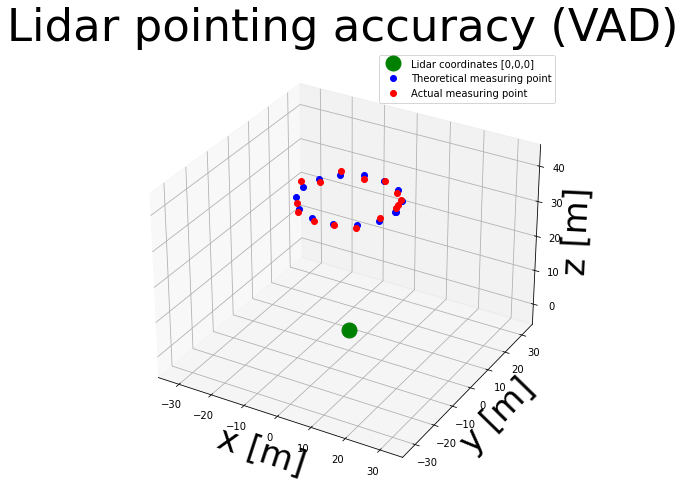

In [17]:
## Ploting:
fig,axs4 = plt.subplots(figsize=(8,8))  
axs4=plt.axes(projection='3d')
axs4.plot(Lidar_origin[0],Lidar_origin[1],Lidar_origin[2],'go',markersize=15,label='{} coordinates [{},{},{}]'.format('Lidar',Lidar_origin[0],Lidar_origin[1],Lidar_origin[2]))
axs4.plot(X0,Y0,Z0,'bo',label='Theoretical measuring point')
axs4.plot(NoisyX,NoisyY,NoisyZ,'ro',label='Actual measuring point')
axs4.set_xlim3d(-35,35)
axs4.set_ylim3d(-35,35)
axs4.set_zlim3d(-5,45)

axs4.set_xlabel('x [m]',fontsize=34)#,orientation=plot_param['tick_labelrotation'])
axs4.set_ylabel('y [m]',fontsize=34)#,orientation=plot_param['tick_labelrotation'])
axs4.set_zlabel('z [m]',fontsize=34)        
axs4.set_title('Lidar pointing accuracy (VAD)',fontsize=45)
axs4.legend()

In [18]:
print(X0)
print(len(X0))
print(X)
print(len(X[0]))

[13.678722080049138, 12.228164971172232, 8.368881298364348, 2.861079901001844, -3.210302309615872, -8.649313230702365, -12.384566426270109, -13.680284809864768, -12.281235376591823, -8.463005472722905, -2.9777170902598216, 3.0941275148326746, 8.556485156448856, 12.333370518388746, 13.680805733026748]
15
[array([14.26623569, 13.33703344, 13.67254504, ..., 14.1043161 ,
       14.22463118, 13.49160465]), array([12.03264829, 12.46566614, 12.93136182, ..., 11.73449433,
       11.94059811, 12.58419092]), array([8.20434708, 7.93332196, 8.25211977, ..., 8.30635614, 8.38211209,
       8.52566989]), array([2.91184942, 2.90869681, 2.83090784, ..., 2.8169676 , 2.95026603,
       2.83150012]), array([-3.22944231, -3.14997342, -3.2183443 , ..., -3.26583674,
       -3.08629433, -3.20528033]), array([-8.73953429, -9.36515257, -8.61848935, ..., -8.66229085,
       -8.56046868, -8.37310876]), array([-11.83497046, -12.29852751, -12.86614071, ..., -12.37508647,
       -12.23150916, -12.44151523]), array([

### **Photodetector**

#### Input parameters

In [19]:
# Physical constants:
k = 1.38064852e-23 # Boltzman constant:[m^2 kg s^-2 K^-1]
h = 6.6207004e-34 # Plank constant [m^2 kg s^-1]
e = 1.60217662e-19 # electron charge [C]
c = 2.99792e8 #speed of light [m s^-1]
# Atmospheric temperature
Temperature=300

# Photodetector parameters
name             = 'Photodetector1'  # Introduce your photodetector name.
Wavelength       = 1550.e-9          # Lidar woking wavelength
Photo_BandWidth  = 380.e+9           # Photodetector bandwidth
Load_Resistor    = 50                # [ohms]
Photo_efficiency = .85               # Photodetector efficiency [-]
Dark_Current     = 5e-9              # [A]. Dark current in the photodetector.
Photo_SignalP    = 1e-6
Power_interval   = np.linspace(0,1000,100000) # In [w]. Power interval for the photodetector domain in photodetector SNR plot. 

#unc_func         = uphc.UQ_Photodetector # Function describing Photodetector uncertainty. Further informaion in "UQ_Photonics_Classes.py" comments.

# Responsivity [A/W]
R = Photo_efficiency*e*Wavelength/(h*c)


#### Thermal noise

In [20]:
# SNR 
SNR_thermal_w      = [((R**2)/(4*k*Temperature*Photo_BandWidth/Load_Resistor))*(Power_interval/1000)**2] # SNR  watts
SNR_thermal     = [10*np.log10(SNR_thermal_w)][0]# SNR  dB
# Noise
Thermal_noise_w=4*k*Temperature*Photo_BandWidth/Load_Resistor
Thermal_noise_dB=10*np.log10(Thermal_noise_w)

print('Thermal_noise[w] = '+ str(Thermal_noise_w))
print('Thermal_noise[dB] = '+ str(Thermal_noise_dB))

Thermal_noise[w] = 1.2591514502399997e-10
Thermal_noise[dB] = -98.99922029981319


C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


#### Shot noise

In [21]:
#SNR
SNR_shot_w  = [((R**2)/(2*e*R*Photo_BandWidth))*(Power_interval)/1000]
SNR_shot    = [10*np.log10(SNR_shot_w )][0]

#Noise
Shot_noise_w = 2*e*Dark_Current*Photo_BandWidth
Shot_noise_dB = 10*np.log10(Shot_noise_w)

print('Shot_noise[w] = '+ str(Shot_noise_w))
print('Shot_noise[dB] = '+ str(Shot_noise_dB))

Shot_noise[w] = 6.088271156e-16
Shot_noise[dB] = -152.15506013443118


C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


#### Dark Current noise

In [22]:
#SNR
SNR_DarkCurrent_w  = [((R**2)/(2*e*Dark_Current*Photo_BandWidth))*(Power_interval/1000)**2]
SNR_DarkCurrent = [10*np.log10(SNR_DarkCurrent_w)][0]

#Noise
Dark_current_noise_w = 2*e*Dark_Current*Photo_BandWidth
Dark_current_noise_dB = 10*np.log10(Dark_current_noise_w)

print('DarkCurrent_Noise[w] = '+ str(Dark_current_noise_w))
print('DarkCurrent_Noise[dB] = '+ str(Dark_current_noise_dB))

DarkCurrent_Noise[w] = 6.088271156e-16
DarkCurrent_Noise[dB] = -152.15506013443118


C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


### Combining uncertainties in the photodetector:
To combine this uncertainties we use GUM

In [23]:
Photodetector_comb_w  = np.sqrt((Thermal_noise_w)**2+(Shot_noise_w)**2+(Dark_current_noise_w)**2)
Photodetector_comb_dB = 10*np.log10(Photodetector_comb_w)  #[dB]

print('Photodetector_comb[w] = '+ str(Photodetector_comb_w))
print('Photodetector_comb[dB] = '+ str(Photodetector_comb_dB))

Photodetector_comb[w] = 1.2591514502694378e-10
Photodetector_comb[dB] = -98.99922029971165


### **Optical amplifier**
Optical amplifier noise is dominated and, therefore characterized by the amplified spontaneous emission (ASE)

Input parameters:

In [24]:
FigureNoise = 1 # Degradation of the SNR in dB. Given by the manufature
OA_Gain     = 30 #dB

Optical amplifier noise estimation:

In [25]:
Optical_amplifier_noise_w  = np.array([((10**(FigureNoise/10))*h*(c/Wavelength)*10**(OA_Gain/10))]) # ASE noise --> (**Optics and Photonics) Bishnu P. Pal - Guided Wave Optical Components and Devices_ Basics, Technology, and Applications -Academic Press (2005)
UQ_Optical_amplifier_noise_dB = np.array([10*np.log10((10**(FigureNoise/10))*h*(c/Wavelength)*10**(OA_Gain/10))]) # ASE noise --> (**Optics and Photonics) Bishnu P. Pal - Guided Wave Optical Components and Devices_ Basics, Technology, and Applications -Academic Press (2005)

print('Optical_amplifier_noise[w] = '+ str(Optical_amplifier_noise_w[0]))
print('Optical_amplifier_noise[dB] = '+ str(UQ_Optical_amplifier_noise_dB[0]))

Optical_amplifier_noise[w] = 1.6121011096073779e-16
Optical_amplifier_noise[dB] = -157.92607723097007


### **Expanding uncertainties**
Gum is applied to expand uncertainties and get global lidar uncertainty. The model combines noise from the different lidar modules and computes expanded uncertainty:

In [26]:
Photonics_comb_w=np.sqrt((Photodetector_comb_w)**2+(Optical_amplifier_noise_w)**2)
Photonics_comb_dB=10*np.log10(Photonics_comb_w)

print('Photonics_comb[w] = '  + str(Photonics_comb_w[0]))
print('Photonics_comb[dB] = ' + str(Photonics_comb_dB[0]))

Photonics_comb[w] = 1.2591514502704697e-10
Photonics_comb[dB] = -98.9992202997081


### Plotting photodetector SNR

C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\fcosta\AppData\Local\Continuum\anaconda3\envs\QluncEnv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


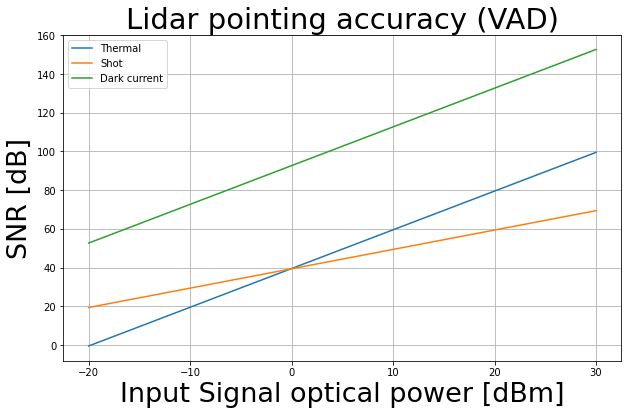

In [27]:
plt.figure(figsize=(10,6)  )
plt.grid(axis='both')
plt.plot(10*np.log10(Power_interval),SNR_thermal[0],label='Thermal')
plt.plot(10*np.log10(Power_interval),SNR_shot[0],label='Shot')
plt.plot(10*np.log10(Power_interval),SNR_DarkCurrent[0],label='Dark current')
plt.xlabel('Input Signal optical power [dBm]',fontsize=27)#,orientation=plot_param['tick_labelrotation'])
plt.ylabel('SNR [dB]',fontsize=27)#,orientation=plot_param['tick_labelrotation'])
plt.title('Lidar pointing accuracy (VAD)',fontsize=29)
plt.legend()

## Hosting Qlunc
Provide a place for Qlunc's documentation

![Sphinx4Qlunc](./Tutorial_Images/SphinxQlunc.PNG)